# Modularity

This analysis answers the question: **"Does modularity differ between task conditions?"**. Individual modularity values are imported for the threshold range of interest. Modularity values for excluded subjects are discarded. Values are subjected into repeated measures ANOVA with two factors (each with two levels) and three effects of interest:

- condition effect `con`: $H_0$ there are no differences in Q between reward and punishment condition
- prediction error effect `perr_sign`: $H_0$ there are no differences in Q between increasing and decreasing prediction errors
- interaction effect `con:perr_sign`: $H_0$ difference in Q between conditions is not modulated by prediction error sign

Test significance is not corrected for multiple comparison (range of γ values).

In [1]:
import json
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dn_utils.misc import tidy_data
from dn_utils.path import path
from dn_utils.style import BLUE, ORANGE, BLUE_PALE, ORANGE_PALE
from scipy.stats import ttest_rel
from statsmodels.stats.anova import AnovaRM

%matplotlib inline

In [2]:
atlas = "combined_roi_4and5"
gamma_range = np.arange(0.5, 2.5, 0.5)

In [3]:
# Load graph measures
path_corrmats = join(path["bsc"], "corrmats")
path_corrmats_unthr = join(path_corrmats, atlas, "unthr")

q = {}
for gamma in gamma_range:
    gamma_str = str(float(gamma)).replace(".", "_")
    path_corrmats_unthr_gamma = join(path_corrmats_unthr, f"gamma_{gamma_str}")
    q[gamma] = np.load(join(path_corrmats_unthr_gamma, "q_aggregated.npy"))

# Load subject exclusion
df_exclusion = pd.read_csv(join(path["nistats"], "exclusion/exclusion.csv"), 
                           index_col=0)
ok_index = df_exclusion["ok_all"]

# Meta information about corrmats dimensions
with open(join(path_corrmats, atlas, "corrmats_aggregated.json"), "r") as f:
    corrmats_meta = json.loads(f.read()) 

In [4]:
# Additional arguments for tidy_data function
labels = [pd.Series(corrmats_meta["dim1"])[ok_index].to_list(),
          corrmats_meta["dim2"],
          corrmats_meta["dim3"]]
palette = {"perr_pos": ORANGE, "perr_neg": BLUE}
palette_con = {"rew": ORANGE_PALE, "pun": BLUE_PALE}

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
con            1.1423 1.0000 28.0000 0.2943
perr_sign      1.9126 1.0000 28.0000 0.1776
con:perr_sign  0.6827 1.0000 28.0000 0.4156

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
con            0.0156 1.0000 28.0000 0.9015
perr_sign      0.8032 1.0000 28.0000 0.3778
con:perr_sign  0.1987 1.0000 28.0000 0.6592

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
con            0.1013 1.0000 28.0000 0.7526
perr_sign      0.6741 1.0000 28.0000 0.4186
con:perr_sign  0.0539 1.0000 28.0000 0.8181

                   Anova
              F Value Num DF  Den DF Pr > F
-------------------------------------------
con            0.3523 1.0000 28.0000 0.5576
perr_sign      0.0045 1.0000 28.0000 0.9472
con:perr_sign  0.0002 1.0000 28.0000 0.9899



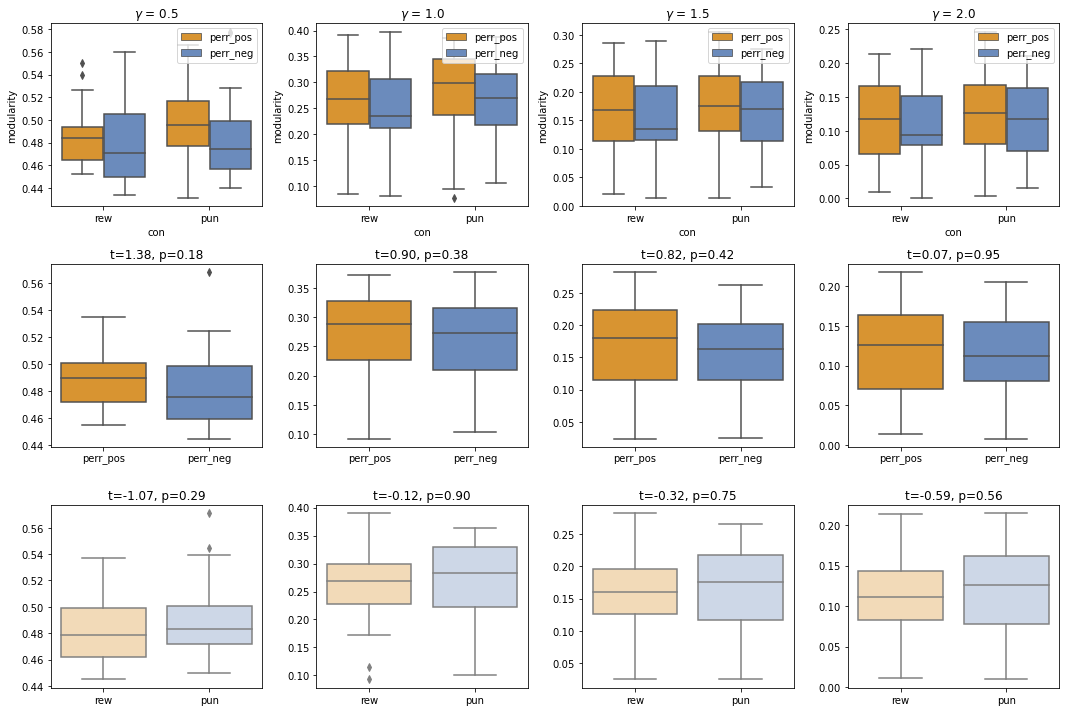

In [5]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(15, 10))

for i, gamma in enumerate(gamma_range):
    
    depvar = "modularity"
    data = tidy_data(
        q[gamma][ok_index],
        depvar=depvar,
        columns=["sub", "con", "perr_sign"],
        labels=labels,
    )
    anova = AnovaRM(
        data=data, 
        depvar=depvar, 
        subject="sub", 
        within=["con", "perr_sign"]
    )
    results = anova.fit()
    print(results)

    sns.boxplot(
        x="con", 
        y=depvar, 
        hue="perr_sign", 
        data=data, 
        ax=axs[0][i], 
        palette=palette
    )
    axs[0][i].set_title(f"$\gamma$ = {gamma}")
    axs[0][i].legend(loc=1)
    
    # Second row (prediction error effect)
    q_perr = np.mean(q[gamma][ok_index], axis=1)
    stats_perr = ttest_rel(q_perr[:, 0], q_perr[:, 1])
    
    sns.boxplot(
        data=pd.DataFrame(q_perr, columns=["perr_pos", "perr_neg"]),
        palette=palette,
        ax=axs[1][i]
    )        
    axs[1][i].set_title(
        f"t={stats_perr.statistic:.2f}, p={stats_perr.pvalue:.2f}",
        fontWeight=400 if stats_perr.pvalue > 0.1 else 800
    )
    if stats_perr.pvalue < 0.05:
        axs[1][i].set_facecolor('#bbb')
    elif stats_perr.pvalue < 0.1:
        axs[1][i].set_facecolor('#eee')
    
    # Third row (condition effect)
    q_con = np.mean(q[gamma][ok_index], axis=2)
    stats_con = ttest_rel(q_con[:, 0], q_con[:, 1])

    sns.boxplot(
        data=pd.DataFrame(q_con, columns=["rew", "pun"]),
        palette=palette_con,
        ax=axs[2][i]
    )        
    axs[2][i].set_title(
        f"t={stats_con.statistic:.2f}, p={stats_con.pvalue:.2f}",
        fontWeight=400 if stats_con.pvalue > 0.1 else 600
    )
    if stats_con.pvalue < 0.05:
        axs[2][i].set_facecolor('#bbb')
    elif stats_con.pvalue < 0.1:
        axs[2][i].set_facecolor('#eee')

    
plt.tight_layout()